dataset from: https://www.kaggle.com/code/exactful/predicting-temp-with-lstm-and-time-series-data/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving DailyDelhiClimateTest.csv to DailyDelhiClimateTest.csv
Saving DailyDelhiClimateTrain.csv to DailyDelhiClimateTrain.csv


In [3]:
# Load data
# index_col indicates the row used to label rows
# parse_index 
train_raw = pd.read_csv('DailyDelhiClimateTrain.csv', index_col='date', parse_dates=True)
test_raw = pd.read_csv('DailyDelhiClimateTest.csv', index_col='date', parse_dates=True)

In [4]:
train_raw.index.freq, test_raw.index.freq

(None, None)

In [5]:
train_raw.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [6]:
# Downsample to monthly means
train = train_raw[['meantemp']].resample('M').mean()
test = test_raw[['meantemp']].resample('M').mean()

In [7]:
train.head()

,meantemp
date,
2013-01-31,12.074770
2013-02-28,16.867560
2013-03-31,22.814209
2013-04-30,28.895119
2013-05-31,33.776767


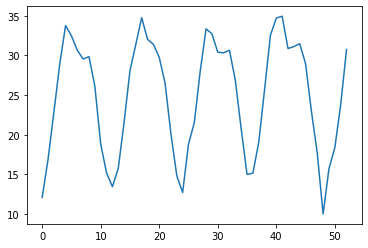

In [8]:
# Plot train and test data
plt.plot(np.append(train, test))

In [9]:
# Scale data - fit around and then transform both train and test
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

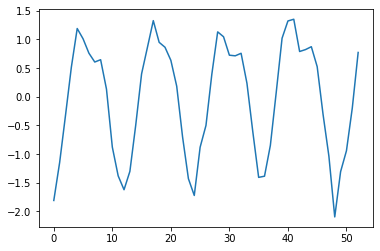

In [11]:
# Plot scaled train and test data
plt.plot(np.append(train_scaled, test_scaled))

In [12]:
# Define generator that provides n_input data points at a time (rolling n input months)
from keras.preprocessing.sequence import TimeseriesGenerator
n_inputs = 9 
n_features = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_inputs, batch_size=1)

In [14]:
# Define model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_inputs, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 9, 128)            66560     
                                                                 
 dropout_2 (Dropout)         (None, 9, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 9, 128)            131584    
                                                                 
 dropout_3 (Dropout)         (None, 9, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 25)               

In [15]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [16]:
# Fit model
history = model.fit(generator, epochs=50)

Epoch 1/50
40/40 [==============================] - 13s 30ms/step - loss: 0.5949 - accuracy: 0.0000e+00
Epoch 2/50
40/40 [==============================] - 1s 29ms/step - loss: 0.3976 - accuracy: 0.0000e+00
Epoch 3/50
40/40 [==============================] - 1s 29ms/step - loss: 0.3057 - accuracy: 0.0000e+00
Epoch 4/50
40/40 [==============================] - 1s 31ms/step - loss: 0.1950 - accuracy: 0.0000e+00
Epoch 5/50
40/40 [==============================] - 1s 30ms/step - loss: 0.2217 - accuracy: 0.0000e+00
Epoch 6/50
40/40 [==============================] - 1s 26ms/step - loss: 0.1654 - accuracy: 0.0000e+00
Epoch 7/50
40/40 [==============================] - 1s 28ms/step - loss: 0.1960 - accuracy: 0.0000e+00
Epoch 8/50
40/40 [==============================] - 1s 28ms/step - loss: 0.1861 - accuracy: 0.0000e+00
Epoch 9/50
40/40 [==============================] - 1s 27ms/step - loss: 0.1688 - accuracy: 0.0000e+00
Epoch 10/50
40/40 [==============================] - 1s 28ms/step - loss

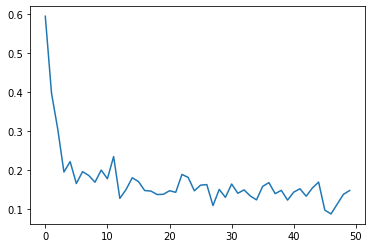

In [17]:
# Plot loss
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [20]:
# Predict
predictions_scaled = []

# Start with the last n_input data points from train_scaled
first_eval_batch = train_scaled[-n_inputs:]

# Create current batch with shape 1 x n_input x n_features
current_batch = first_eval_batch.reshape((1, n_inputs, n_features))

# Predict values over next n_months months
n_months = 36

for i in range(n_months):
  
  # Get the first prediction value based on the current batch (which contains the last n_input months)
  current_pred = model.predict(current_batch)[0]
  
  # Store this value in our predictions list
  predictions_scaled.append(current_pred) 
  
  # Add this value to the end of the current batch and remove the first value (e.g. rolling n_input months)
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [21]:
# Unscale the predictions
predictions = scaler.inverse_transform(predictions_scaled)

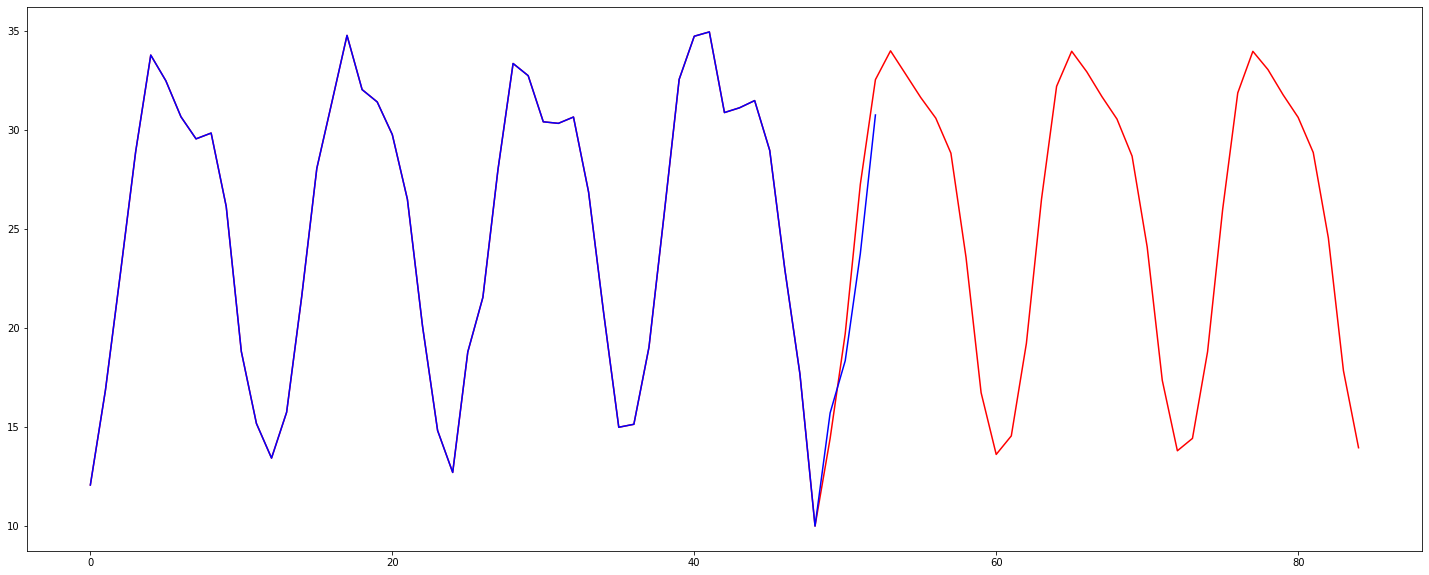

In [22]:
# Plot train+predictions (red) vs train+test (blue)
# Predictions rely only on the last n_input months of train data; beyond that, the predictions are fed back into the model to make new predictions
plt.figure(figsize=(25,10))
plt.plot(np.append(train, predictions), color="red")
plt.plot(np.append(train, test), color="blue")

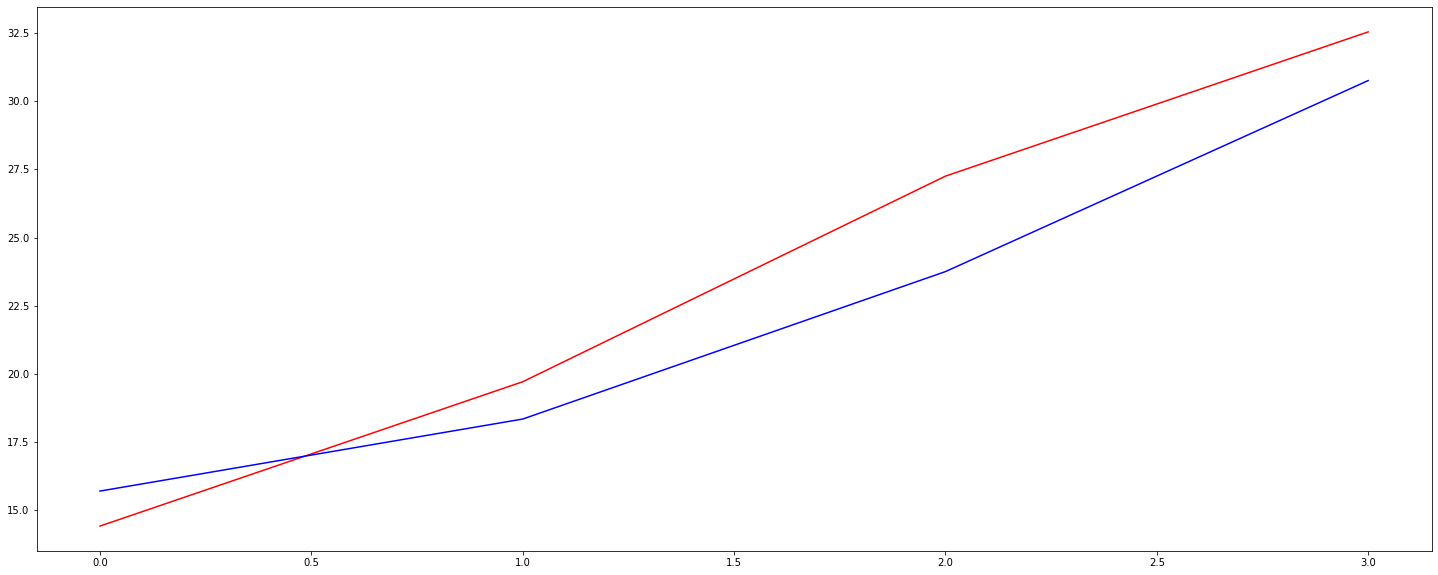

In [23]:
# Plot predictions (red) vs test (blue)
# Predictions rely only on the last n_input months of train data; beyond that, the predictions are fed back into the model to make new predictions
plt.figure(figsize=(25,10))
plt.plot(range(len(test)), predictions[:len(test)], color="red")
plt.plot(range(len(test)), test["meantemp"], color="blue")

In [24]:
# Calc RMSE using test (4 data points) and predictions (same number of data points)
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions[:len(test)]))
print(f"RMSE: {round(rmse, 3)}")

RMSE: 2.176
